In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:
# %%file cluster_configs/cre_setup_3_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 11, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [7]:
config_list = ['cre_setup_3_scale_1_node_info']

In [9]:
config_file = config_list[0]

In [ ]:
# def run_bftsmart_mc(config_file):


os.system('cp cluster_configs/'+config_file+'.csv node_info.csv')


df =pd.read_csv('node_info.csv')

node_info_dict = df.to_dict()

node_info_dict

total_count = 0

for key in node_info_dict['ServerOrClientregion'].keys():
    if node_info_dict['ServerOrClientregion'][key] ==0:
        total_count = total_count + 1

total_count

replica_count = 0

for key in node_info_dict['cluster_id'].keys():
    if node_info_dict['cluster_id'][key] ==0:
        replica_count = replica_count + 1


replica_count       

node_info_dict




n_clusters = int(total_count / replica_count)

nclients = 0

for i in node_info_dict['ServerOrClientregion']:
#     print(node_info_dict['ServerOrClientregion'][i])
    if node_info_dict['ServerOrClientregion'][i] == 1:
        nclients = nclients + 1
nclients

clusters_tracked = []
cluster_regions_tracked = []

for key in node_info_dict['region']:
    if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
        clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
        cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


cluster_regions_tracked     

cluster_regions_tracked, clusters_tracked


regions = cluster_regions_tracked


# regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
#            'europe-west3-c', 'europe-west3-c', 'europe-west3-c', 'europe-west3-c', \
#            'asia-south1-c', 'asia-south1-c', 'asia-south1-c', 'asia-south1-c']


# regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b']


# regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
#            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b', \
#            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



# regions = [ 'europe-west3-c', 'asia-south1-c']

# regions = [ 'us-west1-b', 'us-west1-b']



# regions = [ 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b']
# regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



# regions = ['europe-west3-c',  \
#            'asia-south1-c']


n_regions = len(regions)

for i,k in enumerate(regions):
    print(i,k)

for item, idx in enumerate(node_info_dict['region'].keys()):
    print(item, idx, node_info_dict['region'][item])

lines  = []
# zones = {}


# lim = 0
# for reg in regions:
#     for i in range(replica_count+int(nclients/n_clusters)):
#         line = 'gcloud compute instances create resdb-'+f"{lim+i:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

#         print(line)
#         lines.append(line)
#         zones[i] = reg

#     lim = lim + replica_count+int(nclients/n_clusters)




# with open('launch_cloud_instances.sh', 'w') as f:
#     for item in lines:
#         f.write(str(item) + '\n')


for idx, key in enumerate( node_info_dict['region'].keys()):

    line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
    lines.append(line)

with open('launch_cloud_instances.sh', 'w') as f:
    for item in lines:
        f.write(str(item) + '\n')


len(lines), node_info_dict['region'][key].strip()[1:-1]


def run_command(command):
    subprocess.call(command, shell=True)

commands = lines

# Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
    # Submit each command to the executor for parallel execution
    futures = [executor.submit(run_command, command) for command in commands]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)


# os.system('sh launch_cloud_instances.sh')

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
        shutil.rmtree(folder)

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")


instance_type = 'e2-small'


redirect = '>'

os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
          redirect+' all_internal_ips')



os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
      redirect+' all_external_ips')












with open('all_internal_ips') as f:
    ipList = f.read().splitlines()
ipList = [x for x in ipList if x!='None']







ipList, len(ipList)

new_server_only_ips= []
new_client_only_ips= []



for i in range(total_count + nclients):
    if node_info_dict['ServerOrClientregion'][i] ==0:
        new_server_only_ips = new_server_only_ips + [ipList[i]]
    else:
        new_client_only_ips = new_client_only_ips + [ipList[i]]



# new_server_only_ips= []
# new_client_only_ips= []


# current_region_total = 0
# for i in range(n_regions):
#     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
#     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

#     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
#                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


#     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]



new_server_only_ips, len(new_server_only_ips)

new_client_only_ips, len(new_client_only_ips) 

ipList = new_server_only_ips + new_client_only_ips

ipList, len(ipList)

nclients = 0
nservers = 0
count = 0

clusterIpMap = {}


for i in node_info_dict['ServerOrClientregion']:
#     print(node_info_dict['ServerOrClientregion'][i])

    if node_info_dict['ServerOrClientregion'][i] == 0:
        clusterIpMap[nservers] = ipList[count]
        nservers = nservers + 1

    count = count + 1

nclients = 0
nservers = 0
count = 0

for i in node_info_dict['ServerOrClientregion']:
#     print(node_info_dict['ServerOrClientregion'][i])

    if node_info_dict['ServerOrClientregion'][i] == 1:
        clusterIpMap[7001+nclients] = ipList[count]
        nclients = nclients + 1

    count = count + 1



clusterIpMap

# clusterIpMap = {}

# for i in range(len(ipList)):
#     clusterIpMap[i] = ipList[i]


# for i in range(nclients):

#     clusterIpMap[7001+i] = ipList[-(nclients-i)]

clusterPortMap1 = {}
clusterPortMap2 = {}

for i in range(len(ipList) - nclients):

    clusterPortMap1[i] = str(10000)

for i in range(len(ipList) - nclients):
    clusterPortMap2[i] = str(20000)

# clusterPortMap1[7003] = '11400'
# clusterPortMap2[7003] = '11410'



temp = 11900

for i in range(nclients):

    clusterPortMap1[7001+i] = str(10000)
    clusterPortMap2[7001+i] = str(20000)

clusterPortMap1, clusterPortMap2

os.system('echo 3108 | sudo -S ./gradlew installDist')

for i in range(total_count):
    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

os.system('echo 3108 | sudo -S ./gradlew clean')

for key in clusterPortMap1.keys():
    if key>7002:
        print(key)
        print()

        for folder in os.listdir('config/'):
            if os.path.isdir('config/'+folder) and 'keys' in folder:
                if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                    shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                    shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

        print('----------')
        print()

for i in range(n_clusters):

    if os.path.exists('config'+str(i)):
        shutil.rmtree('config'+str(i))

    os.mkdir('config'+str(i))
    os.mkdir('config'+str(i)+'/keysRSA')
    os.mkdir('config'+str(i)+'/keysSunEC')
    os.mkdir('config'+str(i)+'/keysECDSA')

    print('config'+str(i)+'/keysECDSA')


    shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
    shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
    print('config/workloads/', 'config'+str(i)+'/workloads')


    for file in os.listdir('config/keys/'):

        shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
        shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
        shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


    shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
    shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





clusterIpMap, clusterPortMap1

def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    # If the value is not found, you might want to handle this case accordingly.
    return None


node_info_dict

find_key_by_value(node_info_dict['ServerID'], 4)

for n_cluster in range(n_clusters):

    with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        for key in clusterIpMap:
            if key < 7000:
                file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')

        for key in clusterIpMap:
            if key >= 7000:
                file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')


        file.close()


# for n_cluster in range(n_clusters):

#     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

#         for n_cluster1 in range(n_clusters):

#             for i_replica in range(replica_count):
#     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
#                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

#         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
#             print((n_clusters*replica_count) + iter_)

# #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
#             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

#         for i in range(nclients):
#             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


#         file.close()


replica_count

# for n_cluster in range(n_clusters):
#     with open('config'+str(n_cluster)+'/system.config','r') as file:
#         data = file.readlines()
#         f = int(np.ceil((replica_count-1)/3))
#         print('f is',f )

#         for n_line in range(len(data)):
#             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


#                 data[n_line] = 'system.servers.num = '+str(replica_count)
#                 print(data[n_line])

#             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
#                 data[n_line] = 'system.servers.f = '+str(f)
#                 print(data[n_line])


#             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
#                 data[n_line] = 'system.initial.view = '
#                 for iter_view in range(replica_count):
#                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
# #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
#                     print(data[n_line])

#                 data[n_line] = data[n_line][:-1]
#                 print(data[n_line])



#         file.close()

#     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
#         for line in data:
#             f.write(f"{line}\n")




for n_cluster in range(n_clusters):
    with open('config'+str(n_cluster)+'/system.config','r') as file:
        data = file.readlines()


        nservers = 0
        server_id_list = []



        for i in node_info_dict['ServerOrClientregion']:
            if node_info_dict['ServerOrClientregion'][i] == 0 and \
            node_info_dict['cluster_id'][i]  == n_cluster:
                nservers = nservers + 1
                server_id_list.append(node_info_dict['ServerID'][i])

        f = int(np.ceil((nservers-1)/3))
        print('f is',f )


        for n_line in range(len(data)):
            if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                data[n_line] = 'system.servers.num = '+str(nservers)
                print(data[n_line])

            if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                data[n_line] = 'system.servers.f = '+str(f)
                print(data[n_line])


            if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                data[n_line] = 'system.initial.view = '
                for iter_view in server_id_list:
                    data[n_line] = data[n_line] +str(iter_view)+','
#                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                    print(data[n_line])

                data[n_line] = data[n_line][:-1]
                print(data[n_line])



        file.close()

    with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        for line in data:
            f.write(f"{line}\n")


for n_cluster in range(n_clusters):
    for i in range(400):

        for ncls in  range(1):


            print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                        'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
            shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                        'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
            shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                        'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

#         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
#                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

#         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
#                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

# os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

cp: cannot stat 'cluster_configs/cre_setup_3_scale_1_node_info.csv': No such file or directory


0 europe-west3-c
1 europe-west3-c
2 asia-south1-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.16  34.100.223.48  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.81  34.107.79.172  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.34  35.200.207.90  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.104  35.246.193.35  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.106  34.89.178.12  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.105  34.159.63.63  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.81  34.100.226.208  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



In [4]:
time.sleep(30)

# regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
# regions = [ 'us-west1-b']


instance_type = 'e2-small'

df =pd.read_csv('node_info.csv')

node_info_dict = df.to_dict()

node_info_dict

f = open('all_external_ips', "r")
data1 = [line.strip() for line in f.readlines()]

data1 = [x for x in data1 if x!='None']

f = open('all_internal_ips', "r")
data2 = [line.strip() for line in f.readlines()]

data2 = [x for x in data2 if x!='None']

data2, len(data2)

data = []

skip_instances = 0

for i in range(skip_instances, len(data1)):
    if data1[i]!='None':
        data.append(data1[i] + '    ' + data2[i])

data, len(data)

for index, item in enumerate(data1):
    if 'publicIP' not in node_info_dict.keys():
        node_info_dict['publicIP'] = {}


    node_info_dict['publicIP'][index] = item 


for index, item in enumerate(data2):
    if 'privateIP' not in node_info_dict.keys():
        node_info_dict['privateIP'] = {}

    node_info_dict['privateIP'][index] = item 



for index, item in enumerate(data):
    if 'publicAndprivateIP' not in node_info_dict.keys():
        node_info_dict['publicAndprivateIP'] = {}

    node_info_dict['publicAndprivateIP'][index] = item 

node_info_dict









# time.sleep(60)

total_count = 0

for key in node_info_dict['ServerOrClientregion'].keys():
    if node_info_dict['ServerOrClientregion'][key] ==0:
        total_count = total_count + 1

total_count





def getTimeThps(file, flag):

    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)

    return np.array(times).astype(float), np.array(thputs).astype(float) 

with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1


print(nclusters)





nreplicas = int(total_count/nclusters)
nclients = nclusters


nodeIps = []
clientIps = []

for i in range(total_count + nclients):
    if node_info_dict['ServerOrClientregion'][i] ==0:
        nodeIps.append(lines[i])
    else:
        clientIps.append(lines[i])


# nodeIps = lines[:nclusters* nreplicas]


# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]



# clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes



node_info_dict

node_info_dict['region'][0].strip()

## Functions

def setup(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

        print(command)
        os.system(command)

def initialize(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


        os.system(command)


def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


        os.system(command)

def git_pull(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


        os.system(command)

def compile_job(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


        os.system(command)



def clean_job(i):
    ip = node_info_dict['publicIP'][i] 

    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


        os.system(command)


def clean_all(i):
    ip = node_info_dict['publicIP'][i] 

    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


        os.system(command)





#     if ip!='None' and( ip in no_cluster_yet_nodes):

#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


#         os.system(command)        
# #         print(command)

def check_node(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''

    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

        current = (ip.split('.'))


        cmd_arg = str(node_info_dict['clientID'][i])



        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


        os.system(command)


def kill_java(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None':
        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


        os.system(command)



def kill_clients(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


        os.system(command)

def run_server_node_check(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        print(command)



# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''

    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

        cmd_arg = str(node_info_dict['clientID'][i])


#         print(i, cmd_arg)

        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


        print(command)



## First Time Setup

lines, len(lines)

# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

# ## GIT Clone/Pull



# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


# print(results)  

# ## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

# ## CLEAN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# print(results)  

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


def run_server_node(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

        current = (ip.split('.'))
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


        os.system(command)



# for i in node_info_dict['publicIP']:
#     run_server_node(i)

## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

### CHECK NODE RESULT

# check_node(0)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'multi_client_run_t8_'+str(total_count)+'_clusters_'+str(nclusters)

# time.sleep(60)

os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


#     %%time


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 





results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

time.sleep(180)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

check_node(0)

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 


    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        current = (ip.split('.'))
        command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

        os.system(command)

        break;



for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 



    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        print('client copying id= ',i)
        current = (ip.split('.'))
        command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 


    print(i)
    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        print('client copying id= ',i)


node_info_dict

clientIps



def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
#         print(line)
        if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  



times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = clientIps.index(ip)

    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

    print(times, thputs)
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]


for ip in clientIps[1:]:    
    i = clientIps.index(ip)

    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


    for i in range(len(times)):

        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]

        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]


times_thputsDict



PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)

experiment

# experiment = 'TestRun2_8_clusters_2'
# PIK = '../Experiments/'+experiment+"/pickle.dat"

data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1


pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

times1, lats

lats, np.average(lats[-85:-5])/len(clientIps)

np.sum(thputs),  np.average(thputs[-85:-5])

thputs

np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

# np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

np.sum((thputs[:180]))

np.sum((thputs[:180]))

cp: cannot stat 'cluster_configs/cre_setup_3_scale_1_node_info.csv': No such file or directory


0 europe-west3-c
1 europe-west3-c
2 asia-south1-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-00:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-15:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-08:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-03:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-05:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-07:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c"

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05' already exists

ERROR: (gcloud.compute.instances.create) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zo


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 4s
3 actionable tasks: 3 executed


[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 1s
1 actionable task: 1 executed
7003

----------

config0/keysECDSA
config/workloads/ config0/workloads
config1/keysECDSA
config/workloads/ config1/workloads
config2/keysECDSA
config/workloads/ config2/workloads
f is 1
system.servers.num = 4
system.servers.f = 1
system.initial.view = 0,
system.initial.view = 0,1,
system.initial.view = 0,1,2,
system.initial.view = 0,1,2,3,
system.initial.view = 0,1,2,3
f is 2
system.servers.num = 5
system.servers.f = 2
system.initial.view = 4,
system.initial.view = 4,5,
system.initial.view = 4,5,6,
system.initial.view = 4,5,6,7,
system.initial.view = 4,5,6,7,8,
system.initial.view = 4,5,6,7,8
f is 2
system.servers.num = 5
system.servers.f = 2
system.initial.view = 9,
system.initial.view = 9,10,
system.initial.view = 9,10,11,
system.initial.view = 9,10,11,12,
system.initial.view = 9,10,11,12,13,
system.initial.view = 9,10,11,12,13
config0/keysRSA/publickey7002 config0/keysRSA/publickey1000
config0/keysRSA/publickey7002

config1/keysRSA/publickey7002 config1/keysRSA/publickey1062
config1/keysRSA/publickey7002 config1/keysRSA/publickey1063
config1/keysRSA/publickey7002 config1/keysRSA/publickey1064
config1/keysRSA/publickey7002 config1/keysRSA/publickey1065
config1/keysRSA/publickey7002 config1/keysRSA/publickey1066
config1/keysRSA/publickey7002 config1/keysRSA/publickey1067
config1/keysRSA/publickey7002 config1/keysRSA/publickey1068
config1/keysRSA/publickey7002 config1/keysRSA/publickey1069
config1/keysRSA/publickey7002 config1/keysRSA/publickey1070
config1/keysRSA/publickey7002 config1/keysRSA/publickey1071
config1/keysRSA/publickey7002 config1/keysRSA/publickey1072
config1/keysRSA/publickey7002 config1/keysRSA/publickey1073
config1/keysRSA/publickey7002 config1/keysRSA/publickey1074
config1/keysRSA/publickey7002 config1/keysRSA/publickey1075
config1/keysRSA/publickey7002 config1/keysRSA/publickey1076
config1/keysRSA/publickey7002 config1/keysRSA/publickey1077
config1/keysRSA/publickey7002 config1/ke

[main 29bcd968] Working with modified ClusterInfo
 2745 files changed, 4376 insertions(+), 2750 deletions(-)
 rewrite config/keys/privatekey0 (100%)
 rewrite config/keys/privatekey1 (100%)
 rewrite config/keys/privatekey10 (100%)
 rewrite config/keys/privatekey11 (100%)
 rewrite config/keys/privatekey12 (100%)
 rewrite config/keys/privatekey13 (100%)
 rewrite config/keys/privatekey2 (100%)
 rewrite config/keys/privatekey3 (92%)
 rewrite config/keys/privatekey4 (100%)
 rewrite config/keys/privatekey5 (100%)
 rewrite config/keys/privatekey6 (100%)
 rewrite config/keys/privatekey7 (100%)
 rewrite config/keys/privatekey7001 (100%)
 rewrite config/keys/privatekey7002 (100%)
 rewrite config/keys/privatekey7003 (100%)
 rewrite config/keys/privatekey8 (100%)
 rewrite config/keys/privatekey9 (100%)
 rewrite config0/keysECDSA/privatekey0 (100%)
 rewrite config0/keysECDSA/privatekey1 (100%)
 rewrite config0/keysECDSA/privatekey10 (100%)
 rewrite config0/keysECDSA/privatekey11 (100%)
 rewrite conf

To github.com:tmane002/BftSmart_Final.git
   e44b06c6..29bcd968  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-98.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-101.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-93.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-95.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-100.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-85.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-82.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-94.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-83.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-96.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-99.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-74.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-71.us-west-1.comput

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists...

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease

Reading package lists...
Building dependency tree...Reading package lists...



fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease

Reading state information...
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-secur

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-extra libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
  libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libice6 libllvm12 libpciaccess0 libsensors-config libsensors5 libsm6
  libvulkan1 libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0
  libxcb-shm0 libxcb-syn

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.




Reading package lists...
Reading state information...

Reading state information...
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Reading package lists...

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Reading package lists...Hit:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
curl is already the newest version (7.68.0-1ubuntu2.21).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modesw





job.sh: 12: sdk: not found


Reading package lists...
Reading state information...
Reading package lists...

Building dependency tree...Building dependency tree...Hit:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading state information...
build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...
Reading package lists...
Reading state information...

Building dependency tree...

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-extra libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
  libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libice6 libllvm12 libpciaccess0 libsensors-config libsensors5 libsm6
  libvulkan1 libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0
  libxcb-shm0 libxcb-syn







fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.




curl is already the newest version (7.68.0-1ubuntu2.21).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  at-spi2-core default-jre fonts-dejavu-extra libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libice6 libllvm12 libpciaccess0 libsensors-config
  libsensors5 libsm6 libvulkan1 libwayland-client0 libx11-xcb1 libxaw7
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb



job.sh: 12: sdk: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...
Hit:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease

Reading state information...


Hit:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-extra libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeo

Suggested packages:
  lm-sensors mesa-utils

Reading state information...

Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-extra libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
  libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libice6 libllvm12 libpciaccess0 libsensors-config libsensors5 li


Reading state information...
Reading package lists...
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libice6 libllvm12 libpciaccess0 libsensors-config
  libsensors5 libsm6 libvulkan1 libwayland-client0 libx11-xcb1 libxaw7
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0
  libxcb-shape0 libxcb-shm0 libxcb-sync1 libxcb-xfixes0 libxcomposite1
  libxfixes3 libxft2 libxi6 libxinerama1 libxkbfile1 libxmu6 libxpm4
  libxrandr2 libxrender1 libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1
  libxxf86vm1 mesa-vulkan-drivers openjdk-11-jre x11-common x11-utils
0 upgraded, 60 newly installed, 0 to remove and 65 not upgraded.
Building dependency tree...Need to get 39.7 MB of archives.
After this operation, 537 MB of additional disk space will be used.
Do you want to continue? [Y/n] Ab

job.sh: 12: sdk: not found


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Building dependency tree...build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
  l



job.sh: 12: sdk: not found


build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Suggested packages:
  lm-sensors mesa-utils
The following NEW packages will be installed:
  at-spi2-core default-jre fonts-dejavu-extra libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libice6 libllvm12 libpciaccess0 libsensors-config
  libsensors5 libsm6 libvulkan1 libwayland-client0 libx11-xcb1 libxaw



'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found




job.sh: 12: sdk: not found


Reading package lists...
  at-spi2-core default-jre fonts-dejavu-extra libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libice6 libllvm12 libpciaccess0 libsensors-config
  libsensors5 libsm6 libvulkan1 libwayland-client0 libx11-xcb1 libxaw7
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0
  libxcb-shape0 libxcb-shm0 libxcb-sync1 libxcb-xfixes0 libxcomposite1
  libxfixes3 libxft2 libxi6 libxinerama1 libxkbfile1 libxmu6 libxpm4
  libxrandr2 libxrender1 libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1
  libxxf86vm1 mesa-vulkan-drivers openjdk-11-jre x11-common x11-utils
0 upgraded, 60 newly installed, 0 to remove and 65 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 537 MB of additional disk space will be used.
Do you want to continue? 



job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Building dependency tree...The following additional packages will be installed:
  at-spi2-core fonts-dejavu-extra libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
  libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libice6 libllvm12 libpciaccess0 libsensors-config libsensors5 libsm6
  libvulkan1 libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shap


Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN           

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


The following NEW packages will be installed:
  at-spi2-core default-jre fonts-dejavu-extra libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libice6 libllvm12 libpciaccess0 libsensors-config
  libsensors5 libsm6 libvulkan1 libwayland-client0 libx11-xcb1 libxaw7
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0
  libxcb-shape0 libxcb-shm0 libxcb-sync1 libxcb-xfixes0 libxcomposite1
  libxfixes3 libxft2 libxi6 libxinerama1 libxkbfile1 libxmu6 libxpm4
  libxrandr2 libxrender1 libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1
  libxxf86vm1 mesa-vulkan-drivers openjdk-11-jre x11-common x11-utils

Reading state information...
The following NEW packages will be installed:
  at-spi2-core default-jre fonts-dejavu-extra libatk-bridge2.0-0
  libatk-wrapper-java libatk-

job.sh: 12: sdk: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


 [Y/n] Abort.
Reading package lists...
Building dependency tree...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
ant is already the newest version (1.10.7-1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxm

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...

Reading state information...
Reading package lists...
Reading state information...

Building dependency tree...iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
curl is already the newest version (7.68.0-1ubuntu2.21).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockd

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
job.sh: 12: sdk: not found


Reading package lists...
Building dependency tree...build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxml

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


curl is already the newest version (7.68.0-1ubuntu2.21).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

ant is already the newest version (1.10.7-1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Reading package lists...
Building dependency tree...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...
Reading package lists...
Building dependency tree...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`             

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...

Reading state information...

Reading state information...
ant is already the newest version (1.10.7-1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 u

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


ant is already the newest version (1.10.7-1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
job.sh: 12: sdk: not found


iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 li

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


ant is already the newest version (1.10.7-1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 n

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be 

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main f13e6247] Working with modified ClusterInfo
 1 file changed, 4111 insertions(+), 21229 deletions(-)
 rewrite cre_exp_gc.ipynb (86%)


To github.com:tmane002/BftSmart_Final.git
   29bcd968..f13e6247  main -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
java: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
java: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-clie

Updating e44b06c6..f13e6247
Fast-forward
Updating e44b06c6..f13e6247
Fast-forward
 config/keys/privatekey0          |     2 +-
 config/keys/privatekey1          |     2 +-
 config/keys/privatekey10         |     2 +-
 config/keys/privatekey11         |     2 +-
 config/keys/privatekey12         |     2 +-
 config/keys/privatekey13         |     2 +-
 config/keys/privatekey2          |     2 +-
 config/keys/privatekey3          |     2 +-
 config/keys/privatekey4          |     2 +-
 config/keys/privatekey5          |     2 +-
 config/keys/privatekey6          |     2 +-
 config/keys/privatekey7          |     2 +-
 config/keys/privatekey7001       |     2 +-
 config/keys/privatekey7002       |     2 +-
 config/keys/privatekey7003       |     2 +-
 config/keys/privatekey8          |     2 +-
 config/keys/privatekey9          |     2 +-
 config/keys/publickey0           |     2 +-
 config/keys/publickey1           |     2 +-
 config/keys/publickey10          |     2 +-
 config/keys/publi

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


nfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/privatekey1220   |     2 +-
 config0/keys

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


 config/keys/privatekey0          |     2 +-
 config/keys/privatekey1          |     2 +-
 config/keys/privatekey10         |     2 +-
 config/keys/privatekey11         |     2 +-
 config/keys/privatekey12         |     2 +-
 config/keys/privatekey13         |     2 +-
 config/keys/privatekey2          |     2 +-
 config/keys/privatekey3          |     2 +-
 config/keys/privatekey4          |     2 +-
 config/keys/privatekey5          |     2 +-
 config/keys/privatekey6          |     2 +-
 config/keys/privatekey7          |     2 +-
 config/keys/privatekey7001       |     2 +-
 config/keys/privatekey7002       |     2 +-
 config/keys/privatekey7003       |     2 +-
 config/keys/privatekey8          |     2 +-
 config/keys/privatekey9          |     2 +-
 config/keys/publickey0           |     2 +-
 config/keys/publickey1           |     2 +-
 config/keys/publickey10          |     2 +-
 config/keys/publickey11          |     2 +-
 config/keys/publickey12          |     2 +-
 config/ke

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


nfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/privatekey1220   |     2 +-
 config0/keys

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


Updating e44b06c6..f13e6247
Fast-forward
nfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/

 config2/keysRSA/privatnfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/privatekey1220   |

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


RSA/privatekey1317   |     2 +-
 config1/keysRSA/privatekey1318   |     2 +-
 config1/keysRSA/privatekey1319   |     2 +-
 config1/keysRSA/privatekey1320   |     2 +-
 config1/keysRSA/privatekey1321   |     2 +-
 config1/keysRSA/privatekey1322   |     2 +-
 config1/keysRSA/privatekey1323   |     2 +-
 config1/keysRSA/privatekey1324   |     2 +-
 config1/keysRSA/privatekey1325   |     2 +-
 config1/keysRSA/privatekey1326   |     2 +-
 config1/keysRSA/privatekey1327   |     2 +-
 config1/keysRSA/privatekey1328   |     2 +-
 config1/keysRSA/privatekey1329   |     2 +-
 config1/keysRSA/privatekey1330   |     2 +-
 config1/keysRSA/privatekey1331   |     2 +-
 config1/keysRSA/privatekey1332   |     2 +-
 config1/keysRSA/privatekey1333   |     2 +-
 config1/keysRSA/privatekey1334   |     2 +-
 config1/keysRSA/privatekey1335   |     2 +-
 config1/keysRSA/privatekey1336   |     2 +-
 config1/keysRSA/privatekey1337   |     2 +-
 config1/keysRSA/privatekey1338   |     2 +-
 config1/keysRSA/privat

 config2/keysRSA/publickeynfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/privatekey1220 

 config2/keysRSA/privatekey1213   |     2 +-
 config2/keysRSA/privatekey1214   |     2 +-
 config2/keysRSA/privatekey1215   |     2 +-
 config2/keysRSA/privatekey1216   |     2 +-
 config2/keysRSA/privatekey1217   |     2 +-
 config2/keysRSA/privatekey1218   |     2 +-
 config2/keysRSA/privatekey1219   |     2 +-
 config2/keysRSA/privatekey1220   |     2 +-
 config2/keysRSA/privatekey1221   |     2 +-
 config2/keysRSA/privatekey1222   |     2 +-
 config2/keysRSA/privatekey1223   |     2 +-
 config2/keysRSA/privatekey1224   |     2 +-
 config2/keysRSA/privatekey1225   |     2 +-
 config2/keysRSA/privatekey1226   |     2 +-
 config2/keysRSA/privatekey1227   |     2 +-
 config2/keysRSA/privatekey1228   |     2 +-
 config2/keysRSA/privatekey1229   |     2 +-
 config2/keysRSA/privatekey1230   |     2 +-
 config2/keysRSA/privatekey1231   |     2 +-
 config2/keysRSA/privatekey1232   |     2 +-
 config2/keysRSA/privatekey1233   |     2 +-
 config2/keysRSA/privatekey1234   |     2 +-
 config2/k

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


keysRSA/publickey1327    |     2 +-
 config0/keysRSA/publickey1328    |     2 +-
 config0/keysRSA/publickey1329    |     2 +-
 config0/keysRSA/publickey1330    |     2 +-
 config0/keysRSA/publickey1331    |     2 +-
 config0/keysRSA/publickey1332    |     2 +-
 config0/keysRSA/publickey1333    |     2 +-
 config0/keysRSA/publickey1334    |     2 +-
 config0/keysRSA/publickey1335    |     2 +-
 config0/keysRSA/publickey1336    |     2 +-
 config0/keysRSA/publickey1337    |     2 +-
 config0/keysRSA/publickey1338    |     2 +-
 config0/keysRSA/publickey1339    |     2 +-
 config0/keysRSA/publickey1340    |     2 +-
 config0/keysRSA/publickey1341    |     2 +-
 config0/keysRSA/publickey1342    |     2 +-
 config0/keysRSA/publickey1343    |     2 +-
 config0/keysRSA/publickey1344    |     2 +-
 config0/keysRSA/publickey1345    |     2 +-
 config0/keysRSA/publickey1346    |     2 +-
 config0/keysRSA/publickey1347    |     2 +-
 config0/keysRSA/publickey1348    |     2 +-
 config0/keysRSA/pu

 config/keys/privatekey0          |     2 +-
 config/keys/privatekey1          |     2 +-
 config/keys/privatekey10         |     2 +-
 config/keys/privatekey11         |     2 +-
 config/keys/privatekey12         |     2 +-
 config/keys/privatekey13         |     2 +-
 config/keys/privatekey2          |     2 +-
 config/keys/privatekey3          |     2 +-
 config/keys/privatekey4          |     2 +-
 config/keys/privatekey5          |     2 +-
 config/keys/privatekey6          |     2 +-
 config/keys/privatekey7          |     2 +-
 config/keys/privatekey7001       |     2 +-
 config/keys/privatekey7002       |     2 +-
 config/keys/privatekey7003       |     2 +-
 config/keys/privatekey8          |     2 +-
 config/keys/privatekey9          |     2 +-
 config/keys/publickey0           |     2 +-
 config/keys/publickey1           |     2 +-
 config/keys/publickey10          |     2 +-
 config/keys/publickey11          |     2 +-
 config/keys/publickey12          |     2 +-
 config/ke

nfig0/keysRSA/privatekey12     |     2 +-
 config0/keysRSA/privatekey1200   |     2 +-
 config0/keysRSA/privatekey1201   |     2 +-
 config0/keysRSA/privatekey1202   |     2 +-
 config0/keysRSA/privatekey1203   |     2 +-
 config0/keysRSA/privatekey1204   |     2 +-
 config0/keysRSA/privatekey1205   |     2 +-
 config0/keysRSA/privatekey1206   |     2 +-
 config0/keysRSA/privatekey1207   |     2 +-
 config0/keysRSA/privatekey1208   |     2 +-
 config0/keysRSA/privatekey1209   |     2 +-
 config0/keysRSA/privatekey1210   |     2 +-
 config0/keysRSA/privatekey1211   |     2 +-
 config0/keysRSA/privatekey1212   |     2 +-
 config0/keysRSA/privatekey1213   |     2 +-
 config0/keysRSA/privatekey1214   |     2 +-
 config0/keysRSA/privatekey1215   |     2 +-
 config0/keysRSA/privatekey1216   |     2 +-
 config0/keysRSA/privatekey1217   |     2 +-
 config0/keysRSA/privatekey1218   |     2 +-
 config0/keysRSA/privatekey1219   |     2 +-
 config0/keysRSA/privatekey1220   |     2 +-
 config0/keys

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


ysRSA/privatekey1026   |     2 +-
 config1/keysRSA/privatekey1027   |     2 +-
 config1/keysRSA/privatekey1028   |     2 +-
 config1/keysRSA/privatekey1029   |     2 +-
 config1/keysRSA/privatekey1030   |     2 +-
 config1/keysRSA/privatekey1031   |     2 +-
 config1/keysRSA/privatekey1032   |     2 +-
 config1/keysRSA/privatekey1033   |     2 +-
 config1/keysRSA/privatekey1034   |     2 +-
 config1/keysRSA/privatekey1035   |     2 +-
 config1/keysRSA/privatekey1036   |     2 +-
 config1/keysRSA/privatekey1037   |     2 +-
 config1/keysRSA/privatekey1038   |     2 +-
 config1/keysRSA/privatekey1039   |     2 +-
 config1/keysRSA/privatekey1040   |     2 +-
 config1/keysRSA/privatekey1041   |     2 +-
 config1/keysRSA/privatekey1042   |     2 +-
 config1/keysRSA/privatekey1043   |     2 +-
 config1/keysRSA/privatekey1044   |     2 +-
 config1/keysRSA/privatekey1045   |     2 +-
 config1/keysRSA/privatekey1046   |     2 +-
 config1/keysRSA/privatekey1047   |     2 +-
 config1/keysRSA/priv

 config2/keysRSA/publickeyUpdating e44b06c6..f13e6247
Fast-forward
1071    |     2 +-
 config2/keysRSA/publickey1072    |     2 +-
 config2/keysRSA/publickey1073    |     2 +-
 config2/keysRSA/publickey1074    |     2 +-
 config2/keysRSA/publickey1075    |     2 +-
 config2/keysRSA/publickey1076    |     2 +-
 config2/keysRSA/publickey1077    |     2 +-
 config2/keysRSA/publickey1078    |     2 +-
 config2/keysRSA/publickey1079    |     2 +-
 config2/keysRSA/publickey1080    |     2 +-
 config2/keysRSA/publickey1081    |     2 +-
 config2/keysRSA/publickey1082    |     2 +-
 config2/keysRSA/publickey1083    |     2 +-
 config2/keysRSA/publickey1084    |     2 +-
 config2/keysRSA/publickey1085    |     2 +-
 config2/keysRSA/publickey1086    |     2 +-
 config2/keysRSA/publickey1087    |     2 +-
 config2/keysRSA/publickey1088    |     2 +-
 config2/keysRSA/publickey1089    |     2 +-
 config2/keysRSA/publickey1090    |     2 +-
 config2/keysRSA/publickey1091    |     2 +-
 config2/keysR

 config/keys/privatekey0          |     2 +-
 config/keys/privatekey1          |     2 +-
 config/keys/privatekey10         |     2 +-
 config/keys/privatekey11         |     2 +-
 config/keys/privatekey12         |     2 +-
 config/keys/privatekey13         |     2 +-
 config/keys/privatekey2          |     2 +-
 config/keys/privatekey3          |     2 +-
 config/keys/privatekey4          |     2 +-
 config/keys/privatekey5          |     2 +-
 config/keys/privatekey6          |     2 +-
 config/keys/privatekey7          |     2 +-
 config/keys/privatekey7001       |     2 +-
 config/keys/privatekey7002       |     2 +-
 config/keys/privatekey7003       |     2 +-
 config/keys/privatekey8          |     2 +-
 config/keys/privatekey9          |     2 +-
 config/keys/publickey0           |     2 +-
 config/keys/publickey1           |     2 +-
 config/keys/publickey10          |     2 +-
 config/keys/publickey11          |     2 +-
 config/keys/publickey12          |     2 +-
 config/ke

From https://github.com/tmane002/BftSmart_Final
   e44b06c6..f13e6247  main       -> origin/main


keysRSA/publickey1327    |     2 +-
 config0/keysRSA/publickey1328    |     2 +-
 config0/keysRSA/publickey1329    |     2 +-
 config0/keysRSA/publickey1330    |     2 +-
 config0/keysRSA/publickey1331    |     2 +-
 config0/keysRSA/publickey1332    |     2 +-
 config0/keysRSA/publickey1333    |     2 +-
 config0/keysRSA/publickey1334    |     2 +-
 config0/keysRSA/publickey1335    |     2 +-
 config0/keysRSA/publickey1336    |     2 +-
 config0/keysRSA/publickey1337    |     2 +-
 config0/keysRSA/publickey1338    |     2 +-
 config0/keysRSA/publickey1339    |     2 +-
 config0/keysRSA/publickey1340    |     2 +-
 config0/keysRSA/publickey1341    |     2 +-
 config0/keysRSA/publickey1342    |     2 +-
 config0/keysRSA/publickey1343    |     2 +-
 config0/keysRSA/publickey1344    |     2 +-
 config0/keysRSA/publickey1345    |     2 +-
 config0/keysRSA/publickey1346    |     2 +-
 config0/keysRSA/publickey1347    |     2 +-
 config0/keysRSA/publickey1348    |     2 +-
 config0/keysRSA/pu

ekey1213   |     2 +-
 config2/keysRSA/privatekey1214   |     2 +-
 config2/keysRSA/privatekey1215   |     2 +-
 config2/keysRSA/privatekey1216   |     2 +-
 config2/keysRSA/privatekey1217   |     2 +-
 config2/keysRSA/privatekey1218   |     2 +-
 config2/keysRSA/privatekey1219   |     2 +-
 config2/keysRSA/privatekey1220   |     2 +-
 config2/keysRSA/privatekey1221   |     2 +-
 config2/keysRSA/privatekey1222   |     2 +-
 config2/keysRSA/privatekey1223   |     2 +-
 config2/keysRSA/privatekey1224   |     2 +-
 config2/keysRSA/privatekey1225   |     2 +-
 config2/keysRSA/privatekey1226   |     2 +-
 config2/keysRSA/privatekey1227   |     2 +-
 config2/keysRSA/privatekey1228   |     2 +-
 config2/keysRSA/privatekey1229   |     2 +-
 config2/keysRSA/privatekey1230   |     2 +-
 config2/keysRSA/privatekey1231   |     2 +-
 config2/keysRSA/privatekey1232   |     2 +-
 config2/keysRSA/privatekey1233   |     2 +-
 config2/keysRSA/privatekey1234   |     2 +-
 config2/keysRSA/privatekey1235  

 config2/keysRSA/publickey1071    |     2 +-
 config2/keysRSA/publickey1072    |     2 +-
 config2/keysRSA/publickey1073    |     2 +-
 config2/keysRSA/publickey1074    |     2 +-
 config2/keysRSA/publickey1075    |     2 +-
 config2/keysRSA/publickey1076    |     2 +-
 config2/keysRSA/publickey1077    |     2 +-
 config2/keysRSA/publickey1078    |     2 +-
 config2/keysRSA/publickey1079    |     2 +-
 config2/keysRSA/publickey1080    |     2 +-
 config2/keysRSA/publickey1081    |     2 +-
 config2/keysRSA/publickey1082    |     2 +-
 config2/keysRSA/publickey1083    |     2 +-
 config2/keysRSA/publickey1084    |     2 +-
 config2/keysRSA/publickey1085    |     2 +-
 config2/keysRSA/publickey1086    |     2 +-
 config2/keysRSA/publickey1087    |     2 +-
 config2/keysRSA/publickey1088    |     2 +-
 config2/keysRSA/publickey1089    |     2 +-
 config2/keysRSA/publickey1090    |     2 +-
 config2/keysRSA/publickey1091    |     2 +-
 config2/keysRSA/publickey1092    |     2 +-
 config2/k

 config1/keysRSA/privatekey1026   |     2 +-
 config1/keysRSA/privatekey1027   |     2 +-
 config1/keysRSA/privatekey1028   |     2 +-
 config1/keysRSA/privatekey1029   |     2 +-
 config1/keysRSA/privatekey1030   |     2 +-
 config1/keysRSA/privatekey1031   |     2 +-
 config1/keysRSA/privatekey1032   |     2 +-
 config1/keysRSA/privatekey1033   |     2 +-
 config1/keysRSA/privatekey1034   |     2 +-
 config1/keysRSA/privatekey1035   |     2 +-
 config1/keysRSA/privatekey1036   |     2 +-
 config1/keysRSA/privatekey1037   |     2 +-
 config1/keysRSA/privatekey1038   |     2 +-
 config1/keysRSA/privatekey1039   |     2 +-
 config1/keysRSA/privatekey1040   |     2 +-
 config1/keysRSA/privatekey1041   |     2 +-
 config1/keysRSA/privatekey1042   |     2 +-
 config1/keysRSA/privatekey1043   |     2 +-
 config1/keysRSA/privatekey1044   |     2 +-
 config1/keysRSA/privatekey1045   |     2 +-
 config1/keysRSA/privatekey1046   |     2 +-
 config1/keysRSA/privatekey1047   |     2 +-
 config1/k

 config2/keysRSA/privatekey1213   |     2 +-
 config2/keysRSA/privatekey1214   |     2 +-
 config2/keysRSA/privatekey1215   |     2 +-
 config2/keysRSA/privatekey1216   |     2 +-
 config2/keysRSA/privatekey1217   |     2 +-
 config2/keysRSA/privatekey1218   |     2 +-
 config2/keysRSA/privatekey1219   |     2 +-
 config2/keysRSA/privatekey1220   |     2 +-
 config2/keysRSA/privatekey1221   |     2 +-
 config2/keysRSA/privatekey1222   |     2 +-
 config2/keysRSA/privatekey1223   |     2 +-
 config2/keysRSA/privatekey1224   |     2 +-
 config2/keysRSA/privatekey1225   |     2 +-
 config2/keysRSA/privatekey1226   |     2 +-
 config2/keysRSA/privatekey1227   |     2 +-
 config2/keysRSA/privatekey1228   |     2 +-
 config2/keysRSA/privatekey1229   |     2 +-
 config2/keysRSA/privatekey1230   |     2 +-
 config2/keysRSA/privatekey1231   |     2 +-
 config2/keysRSA/privatekey1232   |     2 +-
 config2/keysRSA/privatekey1233   |     2 +-
 config2/keysRSA/privatekey1234   |     2 +-
 config2/k

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config2/currentView'rm: cannot remove 'config/cu

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.94, 10.156.0.94
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- getConnection HERE 
-- Reached here inside Server Connection
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_W

XXXXXXXX Started Clients XXXXXXXXXXXX


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.98, 10.156.0.98
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- getConnection HERE 
-- ID = 0
-- N = 4
-- F = 1
-- Port (client <-> server) = 10000
-- Port (server <-> server) = 20000
-- requestTimeout = 50000
-- maxBatch = 100
-- Binded replica to IP address 10.156.0.98
-- SSL/TLS enabled, protocol version: TLSv1.2
-- In current view: ID:0; F:1; Processes:0(/10.156.0.98:10000),1(/10.156.0.101:10000),2(/10.156.0.93:10000),3(/10.156.0.95:10000),
-- Changing Replica
-- Retrieving State
-- Running.
-- Next leader for CID=0: 0
-- iAmLeader awaitUninterruptibly signalled to proceed 
-- did no

 tgtArray, consensusIds, consensusIds[0], lastcid is [4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [0], 0, 0, ocmd = bftsmart.consensus.messages.OtherClusterMessage@58d42b61
-- --> 1: sending OtherClusterMessage message from: 0 -> [4, 5, 6, 7, 8, 9, 10, 11, 12, 13], from_cid_start, from_cid_end is 0, 0
-- Sending message from:0 -> to:10.
-- Sending message from:0 -> to:8.
-- Sending message from:0 -> to:7.
-- Sending message from:0 -> to:11.
-- Sending message from:0 -> to:9.
-- Sending message from:0 -> to:12.
-- Sending message from:0 -> to:13.
-- Sending message from:0 -> to:6.
-- Sending message from:0 -> to:4.
-- Sending message from:0 -> to:5.
-- OtherClusterMessage Sent to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13], with type 2
-- saving msg for execution, with tid: 0, requests: [[[1002:-1608277763:0]]]
-- Ending MC for cId:0,  MCLatency: 43602848
-- Main LOOP othermsgs_received_mc for tid: 0, is temp size, nclusters is 1, 3, temp keyset [0]
-- othermsgs_received_mc for tid: 0, is temp size, nclu

rm: cannot remove 'multi_client_run_t8_14_clusters_3.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/multi_client_run_t8_14_clusters_3/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/multi_client_run_t8_14_clusters_3/nohup_client_1.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/multi_client_run_t8_14_clusters_3/nohup_client_2.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
 2 sec: 37 operations; 37 current ops/sec; [READ AverageLatency(us)=50628.59] 
 50628.59 37 2
[2.] [37.]
 2 sec: 24 operations; 23.98 current ops/sec; [READ AverageLatency(us)=58346.67] 
 58346.67 23.98 2


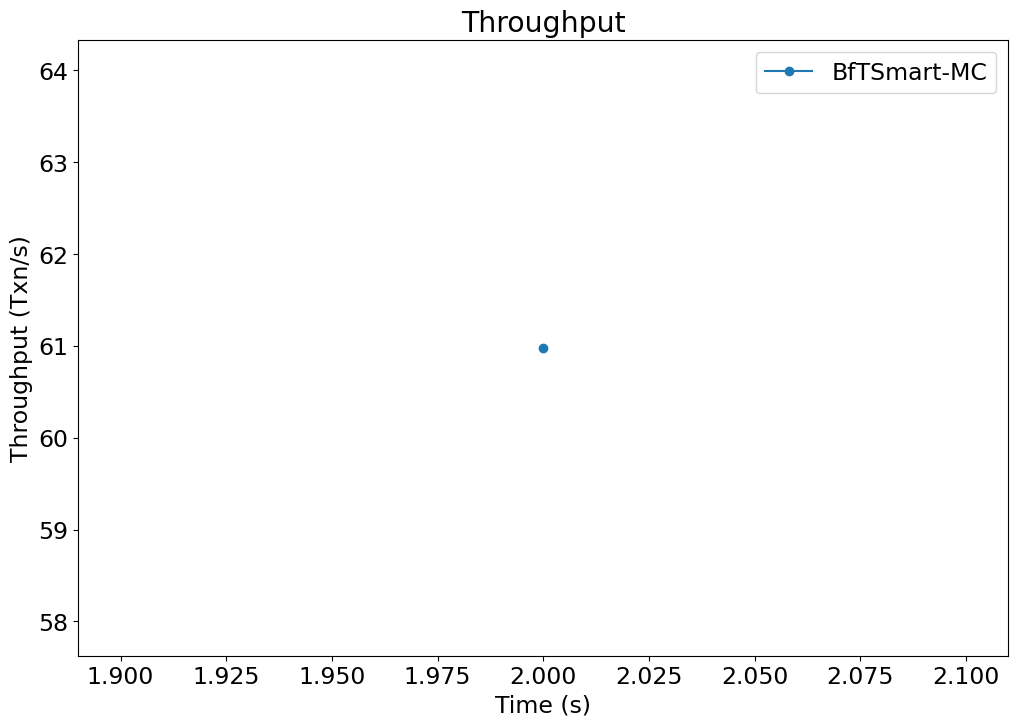

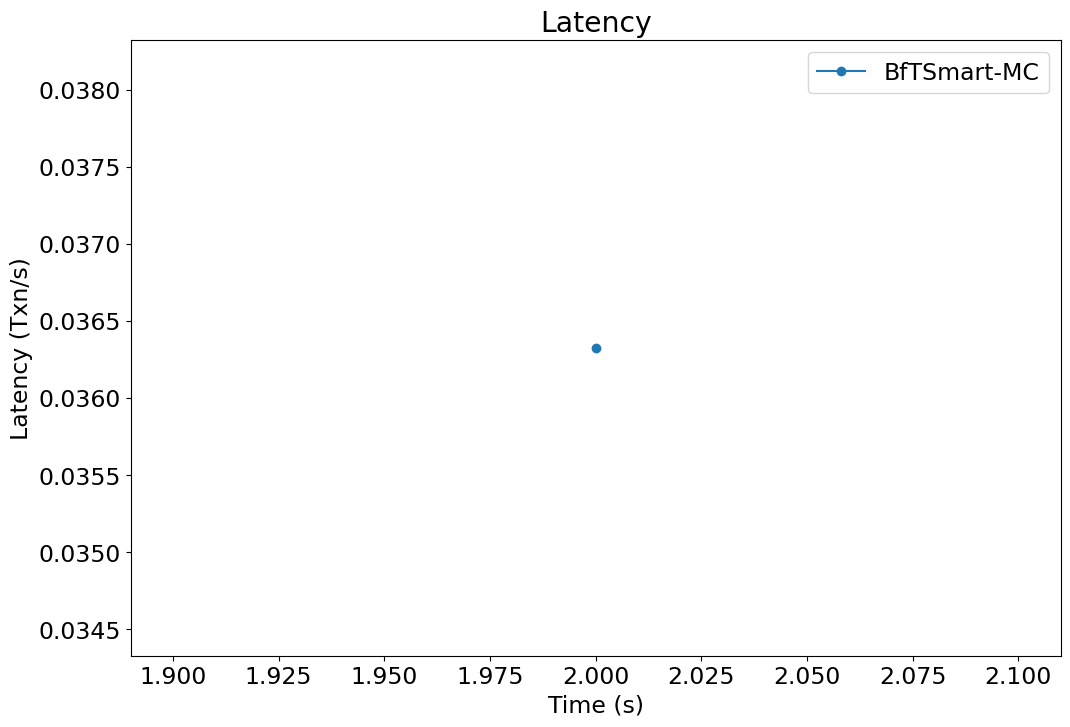

/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gcloud compute scp --zone "europe-west3-c" commands.sh resdb-01:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-10:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-03:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-09:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-13:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-04:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-00:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-02:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-06:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-07:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-05:/home/tejas/commands.sh
gcloud compute scp --zone "asia-s

In [6]:
# %%notify

for cfig in config_list:
    run_bftsmart_mc(cfig)